# Network Experiment Analysis - Complete Regression Suite
Linear, Exponential, and Nonlinear (Rational) Regression Analysis

In [1]:
# Essential setup for VSCode Jupyter
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
import warnings
warnings.filterwarnings('ignore')

# Configure plots for VSCode
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 100
plt.rcParams['figure.figsize'] = (15, 10)

# Try to use seaborn style, fallback to default
try:
    plt.style.use('seaborn-v0_8')
except:
    try:
        plt.style.use('seaborn')
    except:
        plt.style.use('default')

print("✅ Setup complete! Ready for comprehensive regression analysis.")

✅ Setup complete! Ready for comprehensive regression analysis.


## Load Experiment Data

In [18]:
# Load the experiment results
csv_file = "experiment_results/5u_C4_results.csv"  # Change this to your CSV file path

try:
    df = pd.read_csv(csv_file)
    print(f"✅ Loaded {len(df)} experiments from {csv_file}")
    print(f"\n📊 Columns available: {list(df.columns)}")
    print(f"\n📋 First few rows:")
    print(df.head())
except FileNotFoundError:
    print(f"❌ File {csv_file} not found. Please check the file path.")
    print("💡 Make sure to run experiment automation first to generate the CSV file.")
    df = None

✅ Loaded 21 experiments from experiment_results/5u_C4_results.csv

📊 Columns available: ['id', 'timestamp', 'interface', 'speed', 'duration', 'Parallel.', 'Concur.', 'Freq', 'size', 'offered load', 'Observed utilization', 'Total transfer time', 'tx', 'propagation', 'rx_avg', 'rx_median', 'rx_max', 'transfer_avg', 'transfer_max']

📋 First few rows:
        id                   timestamp  interface  speed  duration  Parallel.  \
0  exp2700  2025-08-08T22:25:38.820792  enp7s0np0    NaN        10        NaN   
1  exp2701  2025-08-08T22:26:27.006215  enp7s0np0    NaN        10        NaN   
2  exp2702  2025-08-08T22:27:15.302338  enp7s0np0    NaN        10        NaN   
3  exp2703  2025-08-08T22:28:03.548305  enp7s0np0    NaN        10        NaN   
4  exp2704  2025-08-08T22:28:51.586922  enp7s0np0    NaN        10        NaN   

   Concur.  Freq  size  offered load  Observed utilization  \
0        4   NaN   NaN           NaN              9.105548   
1        4   NaN   NaN           NaN   

## Complete Regression Analysis Suite

In [11]:
def exponential_func(x, a, b, c):
    """Exponential function: y = a * exp(b * x) + c"""
    return a * np.exp(b * x) + c

def rational_function(x, c, a):
    """Rational function: y = c * x / (1 - x) + a
    Note: x must be < 1 for this to be well-defined
    """
    # Ensure x < 1 to avoid division by zero or negative denominators
    x_safe = np.clip(x, 0, 0.999)
    return c * x_safe / (1 - x_safe) + a

def rational_function_2(x, c, a, b):
    """Rational function 2: y = c * x / (1 - x) + a + b*x
    Note: x must be < 1 for this to be well-defined
    """
    # Ensure x < 1 to avoid division by zero or negative denominators
    x_safe = np.clip(x, 0, 0.999)
    return c * x_safe / (1 - x_safe) + a + b * x_safe

def analyze_all_regressions(df, x_col, y_col, title=None):
    """
    Perform linear, exponential, rational, and rational2 regression analysis
    Show only the model comparison plot
    
    Parameters:
    - df: DataFrame with experiment data
    - x_col: Column name for x-axis (independent variable)
    - y_col: Column name for y-axis (dependent variable)
    - title: Optional plot title
    """
    print(f"\n🔍 Comprehensive Analysis: {y_col} vs {x_col}")
    
    # Clean data - remove rows where either column is empty/NaN
    clean_df = df.dropna(subset=[x_col, y_col])
    clean_df = clean_df[(clean_df[x_col] != '') & (clean_df[y_col] != '')]
    
    if len(clean_df) < 3:
        print(f"❌ Not enough data points for regression analysis. Need at least 3, have {len(clean_df)}")
        return
    
    # Convert to numeric
    x = pd.to_numeric(clean_df[x_col], errors='coerce')
    y = pd.to_numeric(clean_df[y_col], errors='coerce')
    
    # Remove any remaining NaN values
    valid_mask = ~(x.isna() | y.isna())
    x = x[valid_mask].values
    y = y[valid_mask].values
    
    if len(x) < 3:
        print(f"❌ Not enough valid numeric data points. Have {len(x)}")
        return
    
    print(f"📊 Analyzing {len(x)} data points")
    print(f"📏 X ({x_col}) range: {x.min():.3f} to {x.max():.3f}")
    print(f"📏 Y ({y_col}) range: {y.min():.3f} to {y.max():.3f}")
    
    # Create single figure for model comparison
    fig, ax = plt.subplots(1, 1, figsize=(14, 9))
    
    # Generate smooth line for plotting
    x_smooth = np.linspace(x.min(), x.max(), 100)
    
    # Scatter plot of observations
    ax.scatter(x, y, alpha=0.7, s=100, color='black', label='Observations', zorder=5, 
              edgecolors='gray', linewidth=0.8)
    
    # === LINEAR REGRESSION ===
    lin_reg = LinearRegression()
    lin_reg.fit(x.reshape(-1, 1), y)
    y_lin_pred = lin_reg.predict(x.reshape(-1, 1))
    y_lin_smooth = lin_reg.predict(x_smooth.reshape(-1, 1))
    
    linear_rmse = np.sqrt(mean_squared_error(y, y_lin_pred))
    r2_linear = lin_reg.score(x.reshape(-1, 1), y)
    
    ax.plot(x_smooth, y_lin_smooth, 'red', linewidth=3, 
            label=f'Linear (RMSE: {linear_rmse:.4f})', alpha=0.8)
    
    # === EXPONENTIAL REGRESSION ===
    exponential_success = False
    try:
        # Initial guess for exponential parameters
        p0 = [1, 0.01, np.mean(y)]
        
        # Fit exponential curve
        popt_exp, _ = curve_fit(exponential_func, x, y, p0=p0, maxfev=5000)
        a_fitted, b_fitted, c_fitted = popt_exp
        
        # Generate predictions
        y_exp_pred = exponential_func(x, *popt_exp)
        exponential_rmse = np.sqrt(mean_squared_error(y, y_exp_pred))
        
        # Generate smooth exponential curve
        y_exp_smooth = exponential_func(x_smooth, *popt_exp)
        ax.plot(x_smooth, y_exp_smooth, 'orange', linewidth=3,
                label=f'Exponential (RMSE: {exponential_rmse:.4f})', alpha=0.8)
        
        exponential_success = True
        
    except Exception as e:
        print(f"⚠️ Exponential fit failed: {str(e)[:50]}...")
        exponential_rmse = float('inf')
    
    # === RATIONAL FUNCTION ===
    rational_success = False
    # For rational function y = c*x/(1-x) + a, we need x < 1
    # Let's normalize x to [0, 0.99] range for fitting
    if x.max() > x.min():
        x_norm = (x - x.min()) / (x.max() - x.min()) * 0.99  # Scale to [0, 0.99]
        
        try:
            # Initial guess for rational function parameters
            p0_rational = [1, np.mean(y)]  # [c, a]
            
            # Fit rational function
            popt_rational, _ = curve_fit(rational_function, x_norm, y, p0=p0_rational, maxfev=5000)
            c_fitted, a_fitted = popt_rational
            
            # Generate predictions
            y_rational_pred = rational_function(x_norm, c_fitted, a_fitted)
            rational_rmse = np.sqrt(mean_squared_error(y, y_rational_pred))
            
            # Generate smooth curve (use original x scale for plotting)
            x_smooth_norm = np.linspace(0, 0.99, 100)
            y_rational_smooth = rational_function(x_smooth_norm, c_fitted, a_fitted)
            # Convert x back to original scale for plotting
            x_smooth_orig = x_smooth_norm / 0.99 * (x.max() - x.min()) + x.min()
            
            ax.plot(x_smooth_orig, y_rational_smooth, 'purple', linewidth=3,
                    label=f'Rational (RMSE: {rational_rmse:.4f})', alpha=0.8)
            
            rational_success = True
            
        except Exception as e:
            print(f"⚠️ Rational fit failed: {str(e)[:50]}...")
            rational_rmse = float('inf')
    else:
        print("⚠️ Cannot normalize x (no range)")
        rational_rmse = float('inf')
    
    # === RATIONAL FUNCTION 2 ===
    rational2_success = False
    if x.max() > x.min():
        try:
            # Initial guess for rational function 2 parameters
            p0_rational2 = [1, np.mean(y), 0]  # [c, a, b]
            
            # Fit rational function 2
            popt_rational2, _ = curve_fit(rational_function_2, x_norm, y, p0=p0_rational2, maxfev=5000)
            c_fitted2, a_fitted2, b_fitted2 = popt_rational2
            
            # Generate predictions
            y_rational2_pred = rational_function_2(x_norm, c_fitted2, a_fitted2, b_fitted2)
            rational2_rmse = np.sqrt(mean_squared_error(y, y_rational2_pred))
            
            # Generate smooth curve (use original x scale for plotting)
            y_rational2_smooth = rational_function_2(x_smooth_norm, c_fitted2, a_fitted2, b_fitted2)
            
            ax.plot(x_smooth_orig, y_rational2_smooth, 'green', linewidth=3, linestyle='--',
                    label=f'Rational 2 (RMSE: {rational2_rmse:.4f})', alpha=0.8)
            
            rational2_success = True
            
        except Exception as e:
            print(f"⚠️ Rational 2 fit failed: {str(e)[:50]}...")
            rational2_rmse = float('inf')
    else:
        rational2_rmse = float('inf')
    
    # Plot formatting
    ax.set_xlabel(x_col, fontsize=14, fontweight='bold')
    ax.set_ylabel(y_col, fontsize=14, fontweight='bold')
    ax.set_title(title or f'Model Comparison: {y_col} vs {x_col}', 
                fontsize=16, fontweight='bold')
    ax.legend(fontsize=11, loc='best')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print comprehensive results
    print(f"\n📊 === COMPREHENSIVE REGRESSION RESULTS ===")
    
    models = [
        ('Linear', linear_rmse, f'y = {lin_reg.coef_[0]:.4f}x + {lin_reg.intercept_:.4f}', r2_linear),
    ]
    
    if exponential_success:
        models.append(('Exponential', exponential_rmse, f'y = {a_fitted:.4f} * exp({b_fitted:.4f}x) + {c_fitted:.4f}', None))
    
    if rational_success:
        models.append(('Rational', rational_rmse, f'y = {c_fitted:.4f} * x/(1-x) + {a_fitted:.4f} [normalized x]', None))
    
    if rational2_success:
        models.append(('Rational 2', rational2_rmse, f'y = {c_fitted2:.4f} * x/(1-x) + {a_fitted2:.4f} + {b_fitted2:.4f}x [normalized x]', None))
    
    # Sort by RMSE (best first)
    models.sort(key=lambda x: x[1])
    
    for i, (name, rmse, equation, r2) in enumerate(models):
        icon = "🥇" if i == 0 else "🥈" if i == 1 else "🥉" if i == 2 else "🏅"
        print(f"\n{icon} {name} Model:")
        print(f"   📐 Equation: {equation}")
        print(f"   📏 RMSE: {rmse:.6f}")
        if r2 is not None:
            print(f"   📈 R² Score: {r2:.6f}")
    
    if len(models) > 1:
        best_model = models[0][0]
        best_rmse = models[0][1]
        second_rmse = models[1][1]
        improvement = ((second_rmse - best_rmse) / second_rmse) * 100
        print(f"\n✅ Best Model: {best_model}")
        print(f"📈 Performance advantage: {improvement:.1f}% better than second-best")
    
    # Data characteristics
    correlation = np.corrcoef(x, y)[0, 1]
    print(f"\n📊 Data Characteristics:")
    print(f"   🔗 Correlation: {correlation:.3f}")
    print(f"   📏 Sample size: {len(x)} points")
    print(f"   📈 X range: {x.min():.3f} to {x.max():.3f}")
    print(f"   📈 Y range: {y.min():.3f} to {y.max():.3f}")
    
    print("\n" + "="*70)

## 🎯 Interactive Analysis
**Configure your analysis:**

In [ ]:
# Load the experiment results
csv_file = "experiment_results/5u_C4_results.csv"  # Change this to your CSV file path

try:
    df = pd.read_csv(csv_file)
    print(f"✅ Loaded {len(df)} experiments from {csv_file}")
    print(f"\n📊 Columns available: {list(df.columns)}")
    print(f"\n📋 First few rows:")
    print(df.head())
except FileNotFoundError:
    print(f"❌ File {csv_file} not found. Please check the file path.")
    print("💡 Make sure to run experiment automation first to generate the CSV file.")
    df = None

🎯 Analysis Configuration:
   X-axis: rx_avg
   Y-axis: transfer_avg

🔍 Comprehensive Analysis: transfer_avg vs rx_avg
📊 Analyzing 21 data points
📏 X (rx_avg) range: 7.398 to 11.209
📏 Y (transfer_avg) range: 0.344 to 0.572


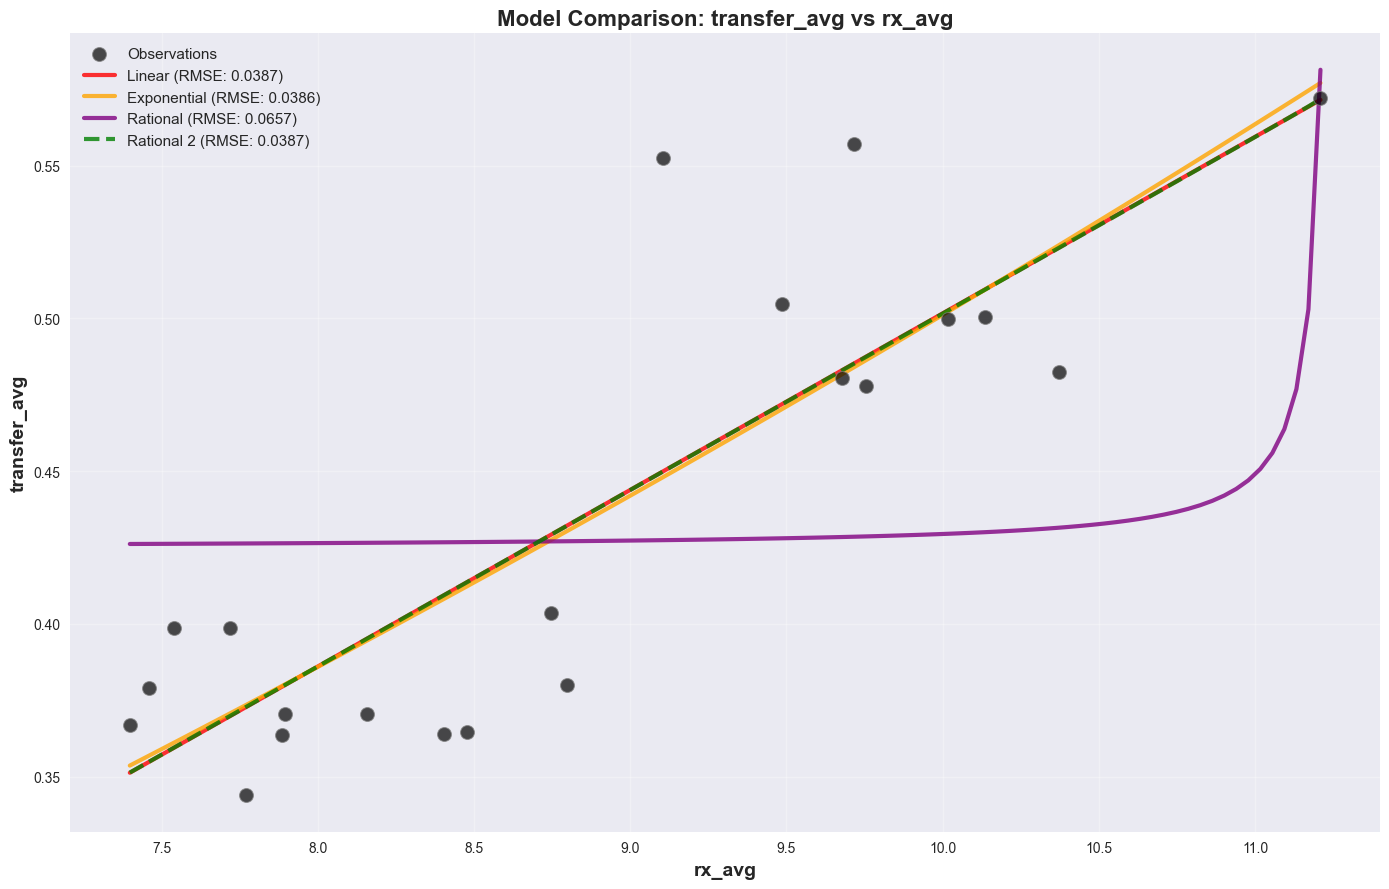


📊 === COMPREHENSIVE REGRESSION RESULTS ===

🥇 Exponential Model:
   📐 Equation: y = 0.4262 * exp(0.0540x) + 0.0016
   📏 RMSE: 0.038609

🥈 Rational 2 Model:
   📐 Equation: y = 0.0000 * x/(1-x) + 0.3513 + 0.2223x [normalized x]
   📏 RMSE: 0.038661

🥉 Linear Model:
   📐 Equation: y = 0.0578x + -0.0763
   📏 RMSE: 0.038661
   📈 R² Score: 0.722707

🏅 Rational Model:
   📐 Equation: y = 0.0016 * x/(1-x) + 0.4262 [normalized x]
   📏 RMSE: 0.065684

✅ Best Model: Exponential
📈 Performance advantage: 0.1% better than second-best

📊 Data Characteristics:
   🔗 Correlation: 0.850
   📏 Sample size: 21 points
   📈 X range: 7.398 to 11.209
   📈 Y range: 0.344 to 0.572



In [19]:
if df is not None:
    # 🎛️ CONFIGURE THESE VARIABLES
    x_column = "rx_avg"  # Independent variable (X-axis)
    y_column = "transfer_avg"  # Dependent variable (Y-axis)
    
    print(f"🎯 Analysis Configuration:")
    print(f"   X-axis: {x_column}")
    print(f"   Y-axis: {y_column}")
    
    # Check if columns exist
    if x_column in df.columns and y_column in df.columns:
        analyze_all_regressions(df, x_column, y_column)
    else:
        print(f"❌ Error: Column '{x_column}' or '{y_column}' not found in data")
        print(f"📋 Available columns: {list(df.columns)}")
else:
    print("❌ No data loaded. Please check the CSV file path in the previous cell.")

## 📊 Quick Analysis Examples
**Try different relationships:**

In [ ]:
if df is not None:
    print("🚀 Quick analysis examples - uncomment to run:")
    
    # # 📈 Concurrency vs Utilization (often shows rational/queuing behavior)
    # analyze_all_regressions(df, "Concur.", "Observed utilization")
    
    # # 📈 Parallel flows vs Transfer time (may show exponential behavior)
    # analyze_all_regressions(df, "Parallel.", "transfer_avg")
    
    # # 📈 Duration vs Transfer time (linear expected)
    # analyze_all_regressions(df, "duration", "transfer_avg")
    
    # # 📈 RX metrics comparison
    # analyze_all_regressions(df, "rx_avg", "rx_max")
    
    print("\n💡 Uncomment the examples above to test different relationships!")
    print("\n📚 Model Guide:")
    print("   🔴 Linear: Simple proportional relationship (y = mx + b)")
    print("   🟠 Exponential: Growth/decay with offset (y = a·exp(bx) + c)")
    print("   🟣 Rational: Queuing theory, saturation effects (y = c·x/(1-x) + a)")
    print("   🟢 Rational 2: Enhanced queuing model (y = c·x/(1-x) + a + bx)")
    print("\n🎯 Model applications:")
    print("   • Linear: Simple scaling relationships")
    print("   • Exponential: Performance growth, congestion effects")
    print("   • Rational: Network utilization vs load, queuing delays with baseline")
    print("   • Rational 2: Complex queuing with linear trend component")
else:
    print("❌ No data available for analysis.")

## 📋 Data Summary

In [ ]:
if df is not None:
    print("📊 === Experiment Data Summary ===")
    print(f"🧪 Total experiments: {len(df)}")
    
    # Show numeric column statistics
    numeric_cols = []
    for col in df.columns:
        try:
            pd.to_numeric(df[col], errors='raise')
            numeric_cols.append(col)
        except:
            pass
    
    if len(numeric_cols) > 0:
        print(f"\n📈 Numeric column statistics:")
        print(df[numeric_cols].describe())
    
    print(f"\n🏷️ Experiment IDs: {sorted(df['id'].dropna().tolist())}")
    
    # Show data completeness
    print(f"\n📊 Data Completeness:")
    for col in df.columns:
        non_empty = df[col].notna().sum()
        total = len(df)
        pct = (non_empty / total) * 100 if total > 0 else 0
        print(f"   {col}: {non_empty}/{total} ({pct:.1f}%)")
else:
    print("❌ No data loaded for summary.")